# Template
## Load modules & Check PyTorch

In [1]:
# Import modules
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd

# data processing
import random as r
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

## Parameters

In [2]:
# Debugger: Aktiviert
debug_mode = True

## Preloaded Modules

In [3]:
def dict_to_markdown_table(data: dict, title: str = "Datenübersicht", include_index: bool = True, round_digits: int = 4):
    """
    Wandelt ein Dictionary mit Listenwerten in eine Markdown-Tabelle für Jupyter Notebooks um.
    
    - Schlüssel werden als Header genutzt
    - Erste Spalte ist ein Index, falls `include_index=True`
    - Einzelwerte werden als separate Tabelle unterhalb dargestellt
    - Zahlenwerte werden auf eine einstellbare Anzahl an Nachkommastellen gerundet

    :param data: Dictionary mit Key-Value-Paaren
    :param title: Überschrift für die Tabelle
    :param include_index: Falls True, wird eine Index-Spalte erstellt
    :param round_digits: Anzahl der Nachkommastellen, auf die Werte gerundet werden sollen
    :return: Markdown-String zur Anzeige in Jupyter
    """
    
    # Hilfsfunktion zum Runden von Zahlen
    def round_value(val):
        if isinstance(val, (int, float)):
            return round(val, round_digits)
        return val

    # Listen und einzelne Werte trennen
    list_data = {k: v for k, v in data.items() if isinstance(v, list)}
    single_values = {k: v for k, v in data.items() if not isinstance(v, list)}

    # Falls es Listen gibt, erstelle eine Tabelle mit Index
    if list_data:
        max_len = max(len(v) for v in list_data.values())  # Längste Liste bestimmen

        # Tabellenkopf
        md_table = f"### {title}\n\n"
        md_table += "| " + ("Index | " if include_index else "") + " | ".join(list_data.keys()) + " |\n"
        md_table += "|-" + ("-|" if include_index else "") + "-|".join(["-" * len(k) for k in list_data.keys()]) + "-|\n"

        # Datenzeilen
        for i in range(max_len):
            row = [str(i)] if include_index else []  # Index hinzufügen (optional)
            for key in list_data:
                if i < len(list_data[key]):
                    row.append(str(round_value(list_data[key][i])))
                else:
                    row.append("")  # Leere Werte für ungleich lange Listen
            md_table += "| " + " | ".join(row) + " |\n"
    
    else:
        md_table = ""

    # Einzelwerte als extra Tabelle darstellen
    if single_values:
        md_table += "\n\n#### Einzelwerte\n\n"
        md_table += "| " + " | ".join(single_values.keys()) + " |\n"
        md_table += "|-" + "-|".join(["-" * len(k) for k in single_values.keys()]) + "-|\n"
        md_table += "| " + " | ".join(map(lambda v: str(round_value(v)), single_values.values())) + " |\n"

    return Markdown(md_table)


def display_data_loss_table(data_dict, delta_sigma_pred, max_i):
    """
    Erstellt eine Markdown-Tabelle zur übersichtlichen Darstellung von Datenverlust.
    
    Unterstützt sowohl Python-Listen als auch NumPy-Arrays.
    
    :param data_dict: Dictionary mit `sigma_t` und `delta_sigma` (Listen oder np.arrays)
    :param delta_sigma_pred: Vorhergesagte Werte für `delta_sigma` (Liste oder np.array)
    :param max_i: Anzahl der Werte, die in der Tabelle angezeigt werden sollen
    """
    
    # Sicherstellen, dass `sigma_t` und `delta_sigma` existieren
    if "sigma_t" not in data_dict or "delta_sigma" not in data_dict or delta_sigma_pred is None:
        print("Fehler: `data_dict` oder `delta_sigma_pred` ist nicht korrekt definiert!")
        return

    # Konvertiere alle Werte zu Listen (falls sie NumPy-Arrays sind)
    def to_list(arr):
        return arr.tolist() if isinstance(arr, np.ndarray) else arr

    total_epsilon = to_list(data_dict["total_epsilon"])
    delta_epsilon = to_list(data_dict["delta_epsilon"])
    sigma_t = to_list(data_dict["sigma_t"])
    delta_sigma_true = to_list(data_dict["delta_sigma"])
    delta_sigma_pred = to_list(delta_sigma_pred.flatten())  # Falls `delta_sigma_pred` ein 2D-Array ist
    
    # Überprüfen, ob die Längen konsistent sind
    min_len = min(len(total_epsilon), len(sigma_t), len(delta_epsilon), len(delta_sigma_true), len(delta_sigma_pred), max_i)

    # Erstelle eine Tabelle für die übersichtliche Darstellung
    data_loss_table = {
        "total_epsilon" : list(total_epsilon[:min_len]), 
        "delta_epsilon" : list(delta_epsilon[:min_len]), 
        "sigma_t" : list(sigma_t[:min_len]), 
        "True delta_sigma": list(delta_sigma_true[:min_len]),
        "Predicted delta_sigma": list(delta_sigma_pred[:min_len]),
        "Test-Loss (True - Predicted)": list(np.round(np.array(delta_sigma_true[:min_len]) - np.array(delta_sigma_pred[:min_len]), 5))
    }

    # Markdown-Tabelle für bessere Darstellung in Jupyter
    display(dict_to_markdown_table(data_loss_table, title=f"Data-Loss bis sigma_{min_len-1}", include_index=True))

## Check for use of CONDA if available

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

Device: cuda:0 -- Number of devices: 1


# Recurrent Neural Networks

Just as people do not have to think again each time about the things they have already learned, it is also possible to teach neural networks to recall knowledge they were being taught. This is done in so-called Recurrent Neural Networks (RNNs) with loops inside, which allow information to be retained. Currently the most used architectures of RNNs are Long short-term memory (LSTM) networks. LSTMs are RNNs that overcome the problem of long-term dependencies and thus have achieved the most state-of-the-art results in this area. In this exercise we will look at how to use LSTMs to predict future values using time series data sets.

## Data processing

In [5]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005, 
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]
        
        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])
        
        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen
    
    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])            
    
    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

def plot_input():
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data_dict_raw['sigma_t'], data_dict_raw['delta_sigma'], marker='o', linestyle='-', label='Sigma_0 = 1')
    
    # Formatting
    plt.xlabel('sigma_t')
    plt.ylabel('delta_simga')
    plt.title('Sigma_0 in relation to Sigma_1')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
i = 5000

oedo_para = {
    'max_n': 1, 
    'e_0': 1.0, 
    'C_c': 0.005,   
    'total_epsilon': 0,
    'e_s': 400.0
}

# Vorbereitung Tensoren
sigma_t = []
delta_sigma = []
delta_epsilon =  []
for i in range(i):
    oedo_para['sigma_t'] = r.randrange(0,500)
    oedo_para['delta_epsilon'] = r.uniform(0.0001,0.001)
    oedo = Oedometer(**oedo_para)
    delta_epsilon.append(round(oedo.delta_epsilon[0], 4))
    delta_sigma.append(round(oedo.delta_sigma[0], 2))
    sigma_t.append(round(oedo.sigma_t[0], 2))



In [7]:
data = [['sigma_t'] + sigma_t, ['delta_sigma'] + delta_sigma, ['delta_epsilon'] + delta_epsilon]
import tabulate
table = tabulate.tabulate(data, tablefmt='html')
table

sigma_t,398,240,43,449,32,231,115,362,353,362,176,255,381,446,148,140,5,319,167,34,207,444,73,153,184,270,202,82,364,42,416,8,186,92,353,194,497,284,181,415,110,380,19,367,384,110,143,71,307,167,259,315,253,128,213,314,155,271,151,288,297,398,207,405,63,411,41,209,237,432,492,477,68,88,432,394,386,342,267,237,281,314,245,340,277,123,23,269,55,414,396,123,87,388,19,436,167,193,214,298,109,428,439,490,345,409,303,60,355,442,472,491,64,471,260,10,319,29,130,461,330,216,97,411,334,179,214,13,84,62,30,494,379,408,307,50,259,137,498,414,384,351,177,366,371,126,367,211,57,250,343,378,135,483,219,102,104,147,123,68,272,115,97,76,459,475,486,124,133,143,325,441,277,2,72,358,246,296,227,145,345,175,23,189,336,126,394,241,326,436,165,15,197,425,291,315,243,14,19,50,366,128,19,249,310,287,447,165,114,14,288,146,482,248,418,354,16,312,442,468,226,388,76,142,440,82,96,347,150,99,156,0,430,162,421,22,163,180,438,365,54,186,484,165,493,22,130,492,488,387,480,499,386,428,274,11,397,320,18,83,252,87,470,123,478,107,471,144,124,330,256,190,216,62,432,70,466,163,276,66,258,380,425,315,131,488,375,383,321,67,484,274,108,98,126,116,267,3,257,133,201,440,403,226,53,377,135,492,106,413,460,262,14,280,477,97,193,333,202,382,115,78,151,381,444,421,115,352,375,205,308,447,446,84,191,488,253,456,143,26,182,163,93,312,35,379,12,491,72,344,73,303,13,198,206,294,170,131,263,364,39,178,165,252,479,113,250,257,289,44,243,185,185,249,7,267,398,277,56,292,398,299,283,394,277,339,148,473,421,277,11,339,175,142,190,343,417,429,405,193,217,253,452,73,442,72,473,47,321,13,37,281,325,251,264,11,171,192,325,346,476,271,483,492,260,407,471,422,193,73,122,27,49,16,220,412,305,405,154,169,440,267,159,376,360,231,133,264,67,470,244,478,355,182,161,76,0,298,145,377,25,125,222,224,106,65,296,111,443,86,415,475,450,90,261,270,42,349,59,214,60,276,217,460,304,340,285,136,199,129,155,374,406,393,330,295,226,312,7,92,457,376,4,333,84,75,309,185,433,173,187,487,175,420,447,3,57,236,319,30,271,145,150,141,144,295,334,302,298,383,278,304,77,412,140,242,478,155,370,99,367,467,409,342,132,393,58,399,65,372,259,373,402,148,474,287,436,306,244,95,133,253,476,485,330,397,366,348,299,109,99,97,373,132,27,369,194,24,126,428,187,219,239,12,462,139,290,32,480,483,88,389,171,274,123,251,465,498,103,428,444,53,380,284,241,124,381,483,156,166,444,490,12,424,469,381,433,83,69,291,473,39,254,166,386,471,333,284,308,202,191,412,54,33,434,381,313,469,38,289,404,29,494,375,247,295,254,91,205,308,95,125,436,308,362,266,104,180,95,422,107,377,47,469,145,436,480,407,417,121,148,469,373,429,216,448,331,27,27,152,12,78,313,257,347,362,287,91,384,139,22,152,207,364,455,253,238,346,325,35,41,198,466,450,56,321,317,312,22,390,462,18,104,396,271,43,236,362,364,58,381,114,116,379,40,326,367,474,459,345,408,329,201,32,3,20,316,335,427,131,207,43,337,119,8,151,348,263,12,125,358,69,416,382,117,237,306,497,37,137,149,13,479,385,298,359,375,268,291,81,318,79,403,226,329,10,318,473,107,263,479,245,432,188,96,368,75,350,30,120,184,28,119,396,464,216,99,41,187,25,141,189,255,276,316,480,356,108,41,108,62,352,391,466,432,497,289,159,332,64,26,39,14,350,269,376,392,70,363,304,406,186,255,81,438,200,218,321,314,486,395,480,43,355,42,330,335,26,338,281,296,207,172,149,342,19,55,169,461,154,123,7,205,140,74,491,133,32,311,325,182,7,240,471,45,491,175,92,499,291,97,143,106,292,128,82,364,127,298,137,328,38,240,318,158,183,102,369,303,461,267,367,141,383,12,417,472,364,266,280,240,106,236,136,154,42,344,432,233,268,295,209,76,387,52,457,74,217,27,155,437,175,428,241,142,264,373,44,310,129,460,254,322,92,134,141,111,381,489,384,23,204,163,231,258,229,99,318,361,196,225,255,200,81,321,189,301,229,382,87,149,388,479,481,458,103,318,86,0,365,352,334,110,80,162,67,208,111,425,8,295,311,111,316,326,426,249,201,230,17,51,34,221,79,92,163,318,471,24,339,163,327,19,333,274,463,335,490,303,476,266,225,94,178,223,140,369,344,246,27,410,248,238,462,378,217,377,114,69,401,463,326,271,227,231,472,305,260,401,148,239,492,434,0,254,427

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Beispiel-Daten
data = {
    'input1': sigma_t,
    'input2': delta_epsilon,
    'output': delta_sigma
}

df = pd.DataFrame(data)

# Normalisierung
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Zurück in DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
df_scaled

,input1,input2,output
0,0.797595,0.111111,0.125791
1,0.480962,0.333333,0.204993
2,0.086172,0.444444,0.042082
3,0.899800,0.555556,0.521750
4,0.064128,0.111111,0.012559
...,...,...,...
4995,0.777555,0.555556,0.509444
4996,0.114228,0.888889,0.102547
4997,0.406814,1.000000,0.408923
4998,0.498998,0.777778,0.403504


In [9]:
import torch

def create_dataset(df, lookback=3):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df.iloc[i:i+lookback, :-1].values)  # Input-Features
        y.append(df.iloc[i+lookback, -1])  # Output
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

X, y = create_dataset(df_scaled, lookback=3)

In [10]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Modell initialisieren
model = LSTMModel(input_size=2, hidden_size=50, num_layers=2, output_size=1)


In [11]:
import torch.optim as optim

# Hyperparameter
learning_rate = 0.001
epochs = 100
batch_size = 32

# Optimizer und Loss-Funktion
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


In [12]:
import torch.optim as optim

# Hyperparameter
input_size = X.shape[2]  # Anzahl der Input-Features
hidden_size = 64  # Die Anzahl der Neuronen im LSTM
num_layers = 2  # Anzahl der LSTM-Schichten
output_size = 1  # Output ist eine einzelne Zahl (z. B. Vorhersage)

# Modell, Loss und Optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Liste zum Speichern der Loss-Werte
losses = []

# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    # Verlust speichern
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


C:\Users\lukas\Documents\git_projects\pina_oedometer\venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([4997])) that is different to the input size (torch.Size([4997, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 0.06173210218548775
Epoch 20/100, Loss: 0.054416585713624954
Epoch 30/100, Loss: 0.049810998141765594
Epoch 40/100, Loss: 0.05039411783218384
Epoch 50/100, Loss: 0.04983285441994667
Epoch 60/100, Loss: 0.04981010779738426
Epoch 70/100, Loss: 0.04980813339352608
Epoch 80/100, Loss: 0.0497785322368145
Epoch 90/100, Loss: 0.049776796251535416
Epoch 100/100, Loss: 0.04977523535490036


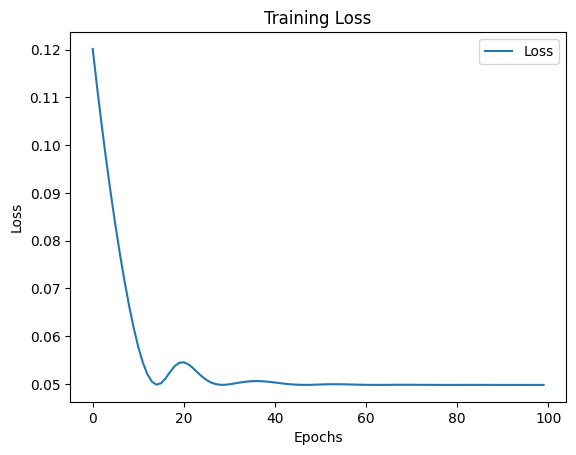

In [14]:
import matplotlib.pyplot as plt
# Plot der Losskurve
plt.plot(range(epochs), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [16]:
# Beispiel: Eingabewerte (z. B. Temperatur und Druck)
test_input = np.array([[1, 0.0005]])  # Zwei Input-Parameter (diese Werte müssen natürlich realistisch sein)

# Normalisieren der Eingabewerte
test_input_scaled = scaler.transform(test_input)

# Umwandeln in Tensoren und Vorhersage durchführen
test_input_tensor = torch.tensor(test_input_scaled, dtype=torch.float32).view(1, 3, -1)  # 1 Beispiel, 3 Zeitschritte, -1 (automatisch die Eingabegröße ermitteln)

model.eval()  # Modell in Evaluierungsmodus setzen
with torch.no_grad():  # Keine Gradientenberechnung
    prediction = model(test_input_tensor)

# Vorhersage zurückskalieren
prediction_rescaled = scaler.inverse_transform([[0, 0, prediction.item()]])[:, -1]  # Nur den Output zurückskalieren
print(f'Vorhersage: {prediction_rescaled[0]}')


C:\Users\lukas\Documents\git_projects\pina_oedometer\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1